In [1]:
# ------------------------------------------------------------
# Configuración
# ------------------------------------------------------------
BASE_DIR = r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2"

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
print("Base:", BASE_DIR)

Base: C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2


In [2]:
# ==========================
#  Variables de calendario
# ==========================
train = pd.read_csv(r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2\data\raw\train.csv", parse_dates=["date"])
test  = pd.read_csv(r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2\data\raw\test.csv",  parse_dates=["date"])

df = train.copy()

df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

df.head()

,date,store,item,sales,day,dayofweek,weekofyear,month,year,is_weekend
0,2013-01-01,1,1,13,1,1,1,1,2013,0
1,2013-01-02,1,1,11,2,2,1,1,2013,0
2,2013-01-03,1,1,14,3,3,1,1,2013,0
3,2013-01-04,1,1,13,4,4,1,1,2013,0
4,2013-01-05,1,1,10,5,5,1,1,2013,1


In [3]:
# ==========================
#  Lags por store-item
# ==========================

df = df.sort_values(["store", "item", "date"])

# Lags simples
for lag in [1, 7, 14, 28]:
    df[f"lag_{lag}"] = df.groupby(["store", "item"])["sales"].shift(lag)

df.head()

,date,store,item,sales,day,dayofweek,weekofyear,month,year,is_weekend,lag_1,lag_7,lag_14,lag_28
0,2013-01-01,1,1,13,1,1,1,1,2013,0,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,2,2,1,1,2013,0,13.0,NaN,NaN,NaN
2,2013-01-03,1,1,14,3,3,1,1,2013,0,11.0,NaN,NaN,NaN
3,2013-01-04,1,1,13,4,4,1,1,2013,0,14.0,NaN,NaN,NaN
4,2013-01-05,1,1,10,5,5,1,1,2013,1,13.0,NaN,NaN,NaN


Entendiendo que en problemas de series de tiempo como el que estamos tratando, las ventas futuras de un producto dependen fuertemente del historial que tiene, generamos algunos rezagos (lags) que consisten en tomar el valor de ventas (sales) en días pasados y utilizarlo como predictor del valor futuro.  
Los rezagos se calculan independientemente para cada combinación (store, item), es decir, las ventas de un ítem en una tienda solo usan como historial sus propias ventas, no las de otros ítems ni otras tiendas.  
- lag_1 captura la inercia inmediata y la continuidad diaria;
- lag_7 permite detectar patrones semanales;
- lag_14 y lag_28 incorporan ciclos quincenales y mensuales que suelen estar asociados a reposición de inventario, hábitos de compra y estacionalidades internas de cada ítem.  

Los primeros días de la serie no tienen historial suficiente para calcular los rezagos, por lo que aparecen como valores faltantes (NaN).


In [4]:
# ==========================
#  Rolling windows
# ==========================

for win in [7, 30]:
    df[f"rolling_mean_{win}"] = (
        df.groupby(["store", "item"])["sales"]
          .shift(1)  # shift para evitar fuga de datos
          .rolling(win)
          .mean()
    )
    df[f"rolling_std_{win}"] = (
        df.groupby(["store", "item"])["sales"]
          .shift(1)
          .rolling(win)
          .std()
    )

df.head()

,date,store,item,sales,day,dayofweek,weekofyear,month,year,is_weekend,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
0,2013-01-01,1,1,13,1,1,1,1,2013,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,2,2,1,1,2013,0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,3,3,1,1,2013,0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,4,4,1,1,2013,0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,5,5,1,1,2013,1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Las ventanas móviles (rolling windows) son estadísticas calculadas sobre los últimos n días de ventas de cada combinación store-item, estas variables permiten que el modelo capture no solo los valores exactos de ventas anteriores (como hacen los lags), sino también tendencias, estabilidad, variabilidad y momentum de la serie.  

A diferencia de los rezagos simples, que representan valores puntuales, las ventanas móviles permiten identificar si la demanda se encuentra en una tendencia creciente o decreciente, así como detectar comportamientos estacionales y ciclos de reposición. Los valores faltantes al inicio del historial corresponden a la falta de datos suficientes para completar las ventanas (por ejemplo, no es posible computar un promedio móvil de 30 días con menos de 30 observaciones), lo cual es esperable en cualquier serie temporal.

In [5]:
# ==========================
#  Limpiar NaNs producidos por lags
# ==========================

df_feats = df.dropna().reset_index(drop=True)

df_feats.shape

(898000, 18)

In [6]:
df_feats[['sales','lag_1','lag_7','lag_14','lag_28',
          'rolling_mean_7','rolling_mean_30']].head()

,sales,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_30
0,13,9.0,8.0,16.0,14.0,10.285714,10.500000
1,11,13.0,14.0,7.0,13.0,11.000000,10.500000
2,21,11.0,12.0,18.0,10.0,10.571429,10.500000
3,15,21.0,12.0,15.0,12.0,11.857143,10.733333
4,14,15.0,11.0,8.0,10.0,12.285714,10.800000


En la tabla final, donde ya se han eliminado los valores faltantes iniciales, puede observarse que los promedios móviles (rolling_mean_7 y rolling_mean_30) suavizan la variabilidad diaria y revelan una tendencia estable alrededor de 10–12 unidades, pese a fluctuaciones como ventas de 21 o 15 unidades. Esto indica que la demanda del ítem presenta una estructura relativamente constante. Los rezagos (lag_1, lag_7, lag_14, lag_28) complementan esta información al capturar dependencias temporales específicas, como estacionalidad semanal y mensual. En conjunto, estas variables permiten al modelo distinguir entre picos aislados, efectos recurrentes y cambios de tendencia, mejorando significativamente su capacidad predictiva frente a modelos basados únicamente en series brutas

In [7]:
# ==========================
#  Guardar datos procesados
# ==========================
output_path = Path(BASE_DIR) / "data" / "processed" / "train_features.csv"
df_feats.to_csv(output_path, index=False)

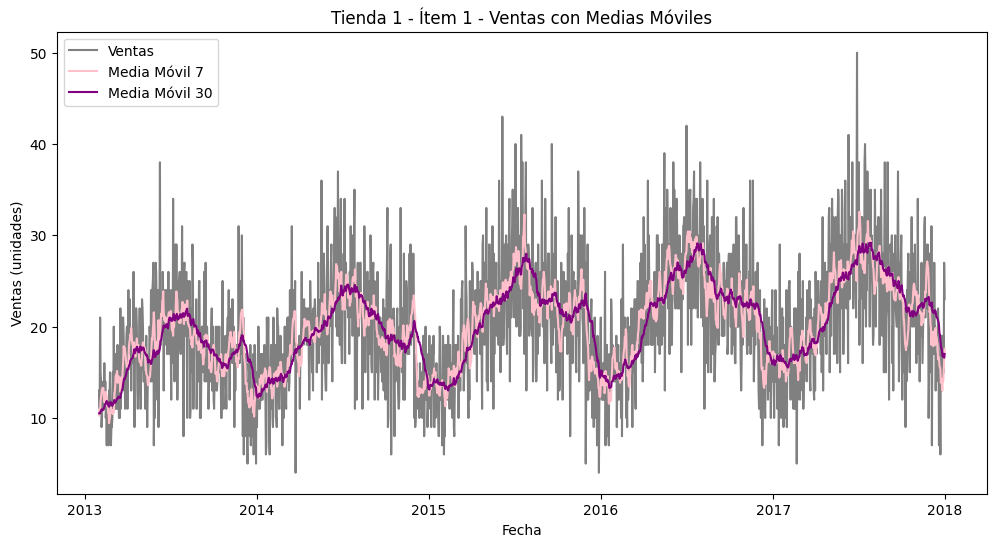

In [24]:
# Graficar rolling mean
store_id = 1
item_id = 1
mask = (df_feats["store"] == store_id) & (df_feats["item"] == item_id)
plt.figure(figsize=(12, 6))
plt.plot(df_feats.loc[mask, "date"], df_feats.loc[mask, "sales"], label="Ventas", color="gray")
plt.plot(df_feats.loc[mask, "date"], df_feats.loc[mask, "rolling_mean_7"], label="Media Móvil 7", color="pink")
plt.plot(df_feats.loc[mask, "date"], df_feats.loc[mask, "rolling_mean_30"], label="Media Móvil 30", color="purple")
plt.title(f"Tienda {store_id} - Ítem {item_id} - Ventas con Medias Móviles")
plt.xlabel("Fecha")
plt.ylabel("Ventas (unidades)")
plt.legend()
plt.show()